## Предсказание стоимости жилья

Необходимо обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Для оценки качества модели будут использованы метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:
- `longitude` — долгота;
- `latitude` — широта;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

# Подготовка данных

## Загрузка данных

In [1]:
#!pip install pyspark

In [2]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import phik

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator as OneHotEncoder

In [3]:
spark = SparkSession.builder \
                    .appName("EDA California Housing") \
                    .master('local') \
                    .config('spark.sql.session.timeZone', 'UTC') \
                    .config('spark.driver.memory','12G') \
                    .config('spark.ui.showConsoleProgress', True) \
                    .config('spark.sql.repl.eagerEval.enabled', True) \
                    .getOrCreate()

In [4]:
df_housing = spark.read.load('./datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10))

df_housing.show(10)

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500

При загрузке данных проблем не обнаружено. В таблице 10 столцов 9 из них типа double и 1 категориальный признак `ocean_proximity`.

## Предобработка данных

In [6]:
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [7]:
def showNa():
    columns = df_housing.columns

    for column in columns:
        check_col = F.isnan(column) | F.isnull(column)
        print(column, df_housing.filter(check_col).count())

In [8]:
showNa()

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [9]:
#Заплним пропуски в данных нулевым значением
df_housing = df_housing.fillna({'total_bedrooms': 0})
showNa()

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [10]:
df_housing.select('ocean_proximity').distinct().collect()

[Row(ocean_proximity='ISLAND'),
 Row(ocean_proximity='NEAR OCEAN'),
 Row(ocean_proximity='NEAR BAY'),
 Row(ocean_proximity='<1H OCEAN'),
 Row(ocean_proximity='INLAND')]

In [11]:
df_housing = df_housing.dropDuplicates()

В данных были обнаружены и удалены пропуски в столбце `total_bedrooms`

# Исследовательский анализ данных

In [12]:
df_housing.select('longitude').describe().show()

+-------+-------------------+
|summary|          longitude|
+-------+-------------------+
|  count|              20640|
|   mean|-119.56970445736442|
| stddev| 2.0035317235025936|
|    min|            -124.35|
|    max|            -114.31|
+-------+-------------------+



In [13]:
df_housing.select('latitude').describe().show()

+-------+------------------+
|summary|          latitude|
+-------+------------------+
|  count|             20640|
|   mean| 35.63186143410874|
| stddev|2.1359523974571224|
|    min|             32.54|
|    max|             41.95|
+-------+------------------+



In [14]:
df_housing.select('housing_median_age').describe().show()

+-------+------------------+
|summary|housing_median_age|
+-------+------------------+
|  count|             20640|
|   mean|28.639486434108527|
| stddev|12.585557612111671|
|    min|               1.0|
|    max|              52.0|
+-------+------------------+



Средний медианный возраст жителей жилых массивов ~ 29 лет. Минимальный медианный возраст 1 год?

In [15]:
df_housing.select('total_rooms').describe().show()

+-------+------------------+
|summary|       total_rooms|
+-------+------------------+
|  count|             20640|
|   mean|2635.7630813953488|
| stddev|2181.6152515827926|
|    min|               2.0|
|    max|           39320.0|
+-------+------------------+



В среднем общее количество комнат в домах жилого массива ~ 2636. В данных есть болшие значения этого признака - 39329.

In [16]:
df_housing.select('total_bedrooms').describe().show()

+-------+-----------------+
|summary|   total_bedrooms|
+-------+-----------------+
|  count|            20640|
|   mean|  532.47621124031|
| stddev|422.6783328108374|
|    min|              0.0|
|    max|           6445.0|
+-------+-----------------+



В среднем общее количество спален в домах жилого массива составляет 532. Мимальное значение 0, максимальное - 6445.

In [17]:
df_housing.select('population').describe().show()

+-------+------------------+
|summary|        population|
+-------+------------------+
|  count|             20640|
|   mean|1425.4767441860465|
| stddev|1132.4621217653419|
|    min|               3.0|
|    max|           35682.0|
+-------+------------------+



Количество человек, которые проживают в жилом массиве в среднем составляет 1425. Возможно стоит обратить внимание, что в данных присутствует достаточно большие значения этого признака.

In [18]:
df_housing.select('households').describe().show()

+-------+------------------+
|summary|        households|
+-------+------------------+
|  count|             20640|
|   mean| 499.5396802325581|
| stddev|382.32975283161085|
|    min|               1.0|
|    max|            6082.0|
+-------+------------------+



В среднем в данных 499 домовладений в жилом массиве. Есть аномальные значения более 6000 домовладений.

In [19]:
df_housing.select('median_income').describe().show()

+-------+------------------+
|summary|     median_income|
+-------+------------------+
|  count|             20640|
|   mean| 3.870671002907026|
| stddev|1.8998217179452666|
|    min|            0.4999|
|    max|           15.0001|
+-------+------------------+



Средний медианный доход жителей составляет 3.9.

In [20]:
df_housing.select('median_house_value').describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             20640|
|   mean|206855.81690891474|
| stddev|115395.61587441401|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



Средняя медианная стоимость дома в жилом массиве составляет 206864. По графику видно, что есть очень много домов с медианной стоимостью ~ 500000, возможно это какой-то элитный жилой массив.

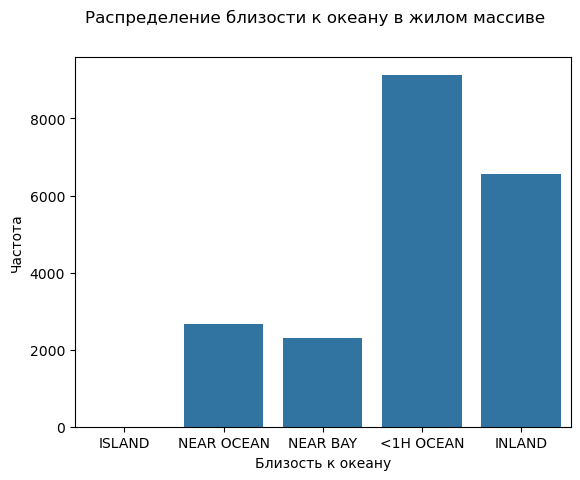

In [21]:
plt.suptitle('Распределение близости к океану в жилом массиве')
df_ocean_count = df_housing.groupBy('ocean_proximity').agg(F.count('ocean_proximity')).toPandas()
ocean_count_hist = sns.barplot(x=df_ocean_count['ocean_proximity'], y=df_ocean_count['count(ocean_proximity)'])
ocean_count_hist.set_xlabel('Близость к океану')
ocean_count_hist.set_ylabel('Частота');

Большиство домов расположены часе езды от океана, на втором месте по количество - дома на материке.

Анализ показал, что в некоторых принзнаках имеются аномальные значения - слишком большие. Возможно стоит учесть эту информацию при обучении моделей.

# Подготовка данных к обучению

In [22]:
RANDOM_STATE = 42

cat_cols = ['ocean_proximity']
num_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
target = 'median_house_value' 

In [23]:
def preparePipeline(num_cols, cat_cols):
    stages = []

    # Обработка категориальных признаков
    if cat_cols != None and len(cat_cols) > 0:
        for categoricalCol in cat_cols:
            #преобразование категориальных колонок в бинарные вектора благодаря строковому преобразователю
            stringIndexer = StringIndexer(inputCol = categoricalCol,
                                        outputCol = categoricalCol + 'Index',
                                        handleInvalid = 'keep')
            encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                                    outputCol=categoricalCol + "classVec")
            stages += [stringIndexer, encoder]

    # Обработка числовых признаков
    numerical_assembler = VectorAssembler(inputCols=num_cols, outputCol="numerical_features")
    stages += [numerical_assembler]

    standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
    stages += [standardScaler]

    assemblerInputs = ['numerical_features_scaled']
    if cat_cols != None and len(cat_cols) > 0:
        assemblerInputs = [c + "classVec" for c in cat_cols] + assemblerInputs
        
    #преобразование нескольких колонок в вектор-колонку - признаки
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

    lin_reg = LinearRegression(labelCol=target, featuresCol='features')
    stages += [lin_reg]

    pipeline = Pipeline(stages=stages)

    return pipeline

In [24]:
train_data, test_data = df_housing.randomSplit([.8,.2], seed=RANDOM_STATE)
print(f'Размер тренировочный выборки {train_data.count()}\nРазмер тестовой выборки {test_data.count()}') 

Размер тренировочный выборки 16560
Размер тестовой выборки 4080


# Обучение моделей

In [25]:
def fitAndScoreModel(num_cols, cat_cols, train_data, test_data):
    pipeline1 = preparePipeline(num_cols, cat_cols)

    # тренируем модель
    model1 = pipeline1.fit(train_data)

    # делаем предсказания на тестовой выборке
    predictions1 = model1.transform(test_data)

    evaluator1 = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value')

    print(f'RMSE: {evaluator1.evaluate(predictions1, {evaluator1.metricName: "rmse"})}')
    print(f'MAE: {evaluator1.evaluate(predictions1, {evaluator1.metricName: "mae"})}')
    print(f'r2: {evaluator1.evaluate(predictions1, {evaluator1.metricName: "r2"})}')

In [26]:
fitAndScoreModel(num_cols, cat_cols, train_data, test_data)

RMSE: 70895.92629941854
MAE: 50949.26389539367
r2: 0.6367243165726155


In [27]:
fitAndScoreModel(num_cols, None, train_data, test_data)

RMSE: 71934.43916829755
MAE: 51936.17292838154
r2: 0.6260035412125817


In [28]:
spark.stop()

Сравнивая метрики двух моделей можно заметить, что метрики модели, обученной на данных без категориальных признаков, немного хуже. Можно предположить, что категориальные признаки, а именно в данном случае близость к океану, незначительно улучшает предсказания модели.

# Общий вывод

В данной работе необходимо было обучить модель линейной регрессии с применением Spark и MLlib на данных о жилье в Калифорнии в 1990 году. На основе данных нужно было предсказать медианную стоимость дома в жилом массиве.

Для повышения качества данных проведена предобработка данных: проверка на явные дубли в данных (не обнаружено), удалены пропущенные значения.

Также проведен исследовательский данных для выявления аномалий и выбросов.

Для обучения моделей к признакам было применено One hot encoding кодирование категориальных принзнаков и масштабирование принзнаков.

Было обучено 2 модели LinearRegression. 1-я модель была обучена на всех признаках, 2-я на данных без категориальных признаков. Первая модель показала лучшие рехультаты, хоть и незначительно. Используемые метрики для определения качества моделей - RMSE, MAE и R2.

Из полученных результатов можно предположить, что улучшения качества предсказаний моделей необходима более детальная работа с признаками, а также возможно нужно провести работу над разработкой новых признаков.